In [1]:
import pymysql
import pandas as pd 
import seaborn as sns
from matplotlib import pyplot as plt
import time

In [44]:
def get_ts_map_start_end(match_id=None): # get map start and end times from pickle
    '''
    parameters: match_id: int

    returns:    ts_match_start, ts_map_start, ts_map_end (int, pandas.Series, pandas.Series)
    '''
    # get map start and end time
    path = 'D:\owl-data\pickles'
    file_name = 'OWL_map_start_info'
    timestamps = pd.read_pickle(os.path.join(path, file_name))

    # send error msg if there is no match_id
    if timestamps['esports_match_id'].isin([match_id]).any() == False:
        raise ValueError('there is no match_id in OWL_map_start_info')

    timestamps = timestamps[timestamps['esports_match_id'] == match_id]
    timestamps[['time_gamestart', 'time_gameresult']] = timestamps[['time_gamestart', 'time_gameresult']] / 1000 # ms to s
    ts_match_start = timestamps['time_gamestart'].min()

    ts_map_start = timestamps['time_gamestart']
    ts_map_start.reset_index(drop=True, inplace=True)
    ts_map_end = timestamps['time_gameresult']
    ts_map_end.reset_index(drop=True, inplace=True)
    
    return ts_match_start, ts_map_start, ts_map_end

In [55]:
# Get event timestamps
def getEvents(match_id=None, ssg=None, stat_lifespan='ROUND', target_hero='no match', team_id=0, threshold=0):
    '''
    parameters: match_id: {esports_match_id} (int)
                ssg: {short_stat_guid} (int)
                stat_lifespan: 'ROUND' (str) optional, {'GAME', 'ROUND', 'MAP_OBJECTIVE'}
                target_hero: 'no match' (str) optional, {hero_name}
                team: 0 (int) optional, {esports_team_id}
                threshold: 0 (float)

    returns:    event_finalblows (pandas.DataFrame[['time', 'amount', 'dx', 'dt']])
    '''
    # Credentials to DB connection
    hostname = "localhost" 
    username = "root"
    pwd = "gpdlzjadh"
    dbname = "esd_phs"
    charset = "utf8"

    # Create connection to MySQL DB
    conn = pymysql.connect(host=hostname, user=username, password=pwd, db=dbname, charset=charset)
    cur = conn.cursor()

    # table names from mysql db
    db_name = 'esd_phs'

    # send query
    table_id = f'match_{match_id}'

    if team_id == 0: # default
        sql = f"select * from `{table_id}` where `stat_lifespan` = '{stat_lifespan}' AND `hero_name` = '{target_hero}' AND `short_stat_guid` = '{ssg}' ORDER BY `time`;"
    else: # where designated team_id
        sql = f"select * from `{table_id}` where `stat_lifespan` = '{stat_lifespan}' AND `hero_name` = '{target_hero}' AND `short_stat_guid` = '{ssg}' AND `esports_team_id` = '{team_id}' ORDER BY `time`;"

    df = pd.read_sql(sql, conn)

    cur.close()
    conn.close()

    # get map start and end time in ms
    ts_match_start, ts_map_start, ts_map_end = get_ts_map_start_end(match_id)

    # get map start times and end times
    map_start_times = ts_map_start - ts_match_start # set match start time as 0
    map_end_times = ts_map_end - ts_match_start # set match start time as 0

    # groupby df
    df2 = df[['time', 'short_stat_guid', 'amount', 'stat_category', 'battletag', 'esports_team_id']]
    df2['time'] = pd.to_numeric(df2['time'])
    df2['time'] = df2['time'] / 1000 # ms to s
    df2['time'] = df2['time'] - ts_match_start # set match start time as 0

    sum_df = df2.groupby(['time', 'short_stat_guid'])[['amount']].sum()

    # remove weired peak data
    for t in map_end_times:
        sum_df.drop(t, level='time', axis=0, inplace=True) # remove weired peak data at the endtime of maps
    
    sum_df = sum_df.droplevel(level='short_stat_guid')
    sum_df = sum_df.reset_index(level='time')
    sum_df['dx'] = sum_df['amount'].diff()
    sum_df['dt'] = sum_df['time'].diff()
    sum_df['dx/dt'] = sum_df['dx'] / sum_df['dt']
    
    # define event time with threshold
    sum_df['event'] = sum_df['dx'] > threshold # True if dx > threshold
    
    # transform time (int) into UTC datetime
    sum_df['time'] += ts_match_start
    sum_df['time'] = pd.to_datetime(sum_df['time'], unit='s', utc=True)
    
    sum_df.set_index('time', inplace=True)

    return sum_df

In [56]:
df = getEvents(match_id=34912, ssg=1208)
display(df)

,amount,dx,dt,dx/dt,event
time,,,,,
2020-08-08 11:44:55.489000082+00:00,12.1197,NaN,NaN,NaN,False
2020-08-08 11:44:57.566999912+00:00,52.1197,40.0000,2.078,19.249280,True
2020-08-08 11:44:59.653000116+00:00,361.8975,309.7778,2.086,148.503245,True
2020-08-08 11:45:01.734999895+00:00,547.4192,185.5217,2.082,89.107454,True
2020-08-08 11:45:03.822000027+00:00,857.4098,309.9906,2.087,148.534059,True
...,...,...,...,...,...
2020-08-08 13:18:22.848999977+00:00,32954.4700,335.8800,2.084,161.170835,True
2020-08-08 13:18:24.927999973+00:00,33414.2200,459.7500,2.079,221.139972,True
2020-08-08 13:18:27.012000084+00:00,33657.4200,243.2000,2.084,116.698650,True


In [63]:
ts_match_start, ts_map_start, ts_map_end = get_ts_map_start_end(34912)

In [65]:
ts_match_start = pd.to_datetime(ts_match_start, unit='s', utc=True)
ts_match_start

Timestamp('2020-08-08 11:44:49.006000042+0000', tz='UTC')

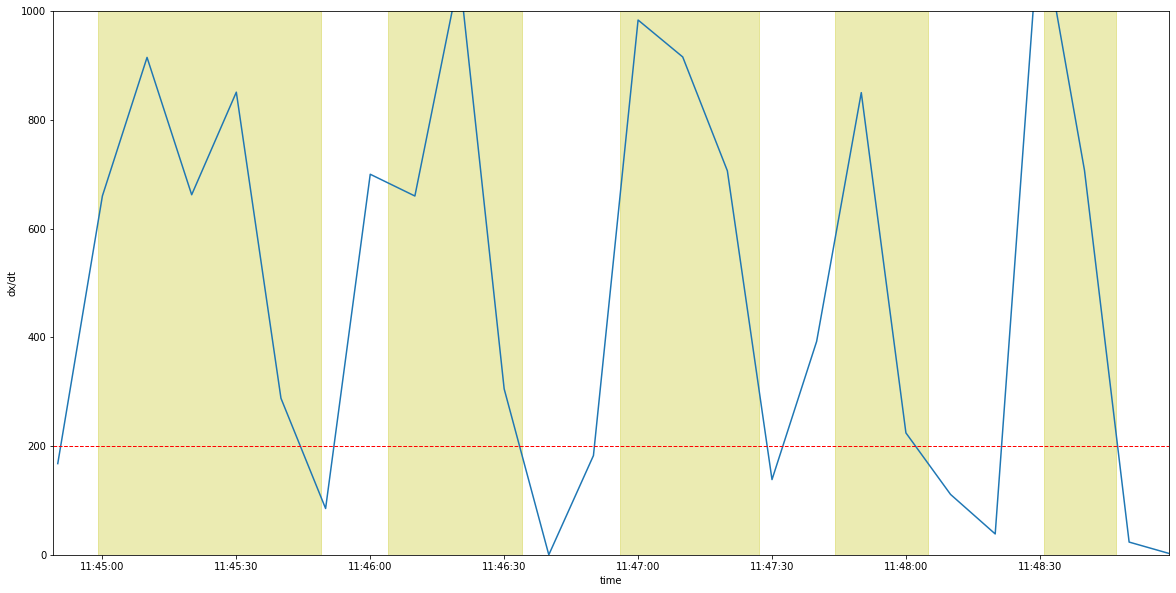

In [83]:
tmp_df2 = df.resample('10S').sum()

plt.figure(figsize=(20,10))
sns.lineplot(x='time', y='dx/dt', data=tmp_df2)

youtube_video_start = 185
TF_start_time_stamps = [10, 75, 127, 120+55, 180+42] # start: 3:05 6:21 6:47 7:03
TF_end_time_stamps = [60, 105, 158, 180+16, 240-2]

TF_start_time_stamps.extend([480+13-youtube_video_start, 540+51-youtube_video_start, 600+51-youtube_video_start, 660+30-youtube_video_start, 600+120+2-youtube_video_start, 600+120+50-youtube_video_start, 600+180+10-youtube_video_start])
TF_end_time_stamps.extend([540+16-youtube_video_start, 600+21-youtube_video_start, 660+18-youtube_video_start, 660+34-youtube_video_start, 600+120+25-youtube_video_start, 600+120+56-youtube_video_start, 600+180+16-youtube_video_start])

TF_start_time_stamps = pd.to_timedelta(TF_start_time_stamps, unit='s')
TF_end_time_stamps = pd.to_timedelta(TF_end_time_stamps, unit='s')

for t, val in enumerate(TF_start_time_stamps):
    plt.axvspan((ts_match_start + TF_start_time_stamps[t]), (ts_match_start + TF_end_time_stamps[t]), color='y', alpha=0.3)

threshold=200
plt.axhline(y=threshold, color='red', linestyle='--', linewidth=1)

plt.xlim(ts_match_start, ts_match_start + pd.to_timedelta(250, unit='s'))
plt.ylim(0,1000)
plt.show()

In [4]:
# Get final blows event timestamps
def getEvents_finalblows(match_id=None, stat_lifespan='ROUND', target_hero='no match', team_id=0, threshold=0):
    '''
    parameters: match_id: {esports_match_id} (int)
                stat_lifespan: 'ROUND' (str) optional, {'GAME', 'ROUND', 'MAP_OBJECTIVE'}
                target_hero: 'no match' (str) optional, {hero_name}
                team: 0 (int) optional, {esports_team_id}
                threshold: 0 (float)

    returns:    event_finalblows (pandas.DataFrame[['time', 'amount', 'dx', 'dt']])
    '''
    # short_stat_guid
    ssg = 44

    # Credentials to DB connection
    hostname = "localhost" 
    username = "root"
    pwd = "gpdlzjadh"
    dbname = "esd_phs"
    charset = "utf8"

    # Create connection to MySQL DB
    conn = pymysql.connect(host=hostname, user=username, password=pwd, db=dbname, charset=charset)
    cur = conn.cursor()

    # table names from mysql db
    db_name = 'esd_phs'

    # send query
    table_id = f'match_{match_id}'

    if team_id == 0: # default
        sql = f"select * from `{table_id}` where `stat_lifespan` = '{stat_lifespan}' AND `hero_name` = '{target_hero}' AND `short_stat_guid` = '{ssg}';"
    else: # where designated team_id
        sql = f"select * from `{table_id}` where `stat_lifespan` = '{stat_lifespan}' AND `hero_name` = '{target_hero}' AND `short_stat_guid` = '{ssg}' AND `esports_team_id` = '{team_id}';"

    df = pd.read_sql(sql, conn)

    cur.close()
    conn.close()

    # get map start and end time in ms
    ts_match_start, ts_map_start, ts_map_end = get_ts_map_start_end(match_id)

    # get map start times and end times
    map_start_times = ts_map_start - ts_match_start # set match start time as 0
    map_end_times = ts_map_end - ts_match_start # set match start time as 0

    # groupby df
    df2 = df[['time', 'short_stat_guid', 'amount', 'stat_category', 'battletag', 'esports_team_id']]
    df2['time'] = pd.to_numeric(df2['time'])
    df2['time'] = df2['time'] / 1000 # ms to s
    df2['time'] = df2['time'] - ts_match_start # set match start time as 0

    sum_df = df2.groupby(['time', 'short_stat_guid'])[['amount']].sum()

    # remove weired peak data
    for t in map_end_times:
        sum_df.drop(t, level='time', axis=0, inplace=True) # remove weired peak data at the endtime of maps
    
    sum_df = sum_df.droplevel(level='short_stat_guid')
    sum_df = sum_df.reset_index(level='time')
    sum_df['dx'] = sum_df['amount'].diff()
    sum_df['dt'] = sum_df['time'].diff()
    sum_df['dx/dt'] = sum_df['dx'] / sum_df['dt']
    
    # define event time with threshold
    sum_df['event'] = sum_df[sum_df['dx'] > threshold]['time']
    
    events_finalblows = sum_df

    return events_finalblows

In [5]:
# Get Hero Damage Done with timestamps
def getEvents_herodamagedone(match_id=None, stat_lifespan='ROUND', target_hero='no match', team_id=0, threshold=400):
    '''
    parameters: match_id: {esports_match_id} (int)
                stat_lifespan: 'ROUND' (str) optional, {'GAME', 'ROUND', 'MAP_OBJECTIVE'}
                target_hero: 'no match' (str) optional, {hero_name}
                team: 0 (int) optional, {esports_team_id}
                threshold: 400 (float)

    returns:    event_alldamagedone (pandas.DataFrame[['time', 'amount', 'dx', 'dt']])
    '''
    # short_stat_guid
    ssg = 1208 # Hero_Damage_Done

    # Credentials to DB connection
    hostname = "localhost" 
    username = "root"
    pwd = "gpdlzjadh"
    dbname = "esd_phs"
    charset = "utf8"

    # Create connection to MySQL DB
    conn = pymysql.connect(host=hostname, user=username, password=pwd, db=dbname, charset=charset)
    cur = conn.cursor()

    # table names from mysql db
    db_name = 'esd_phs'

    # send query
    table_id = f'match_{match_id}'
    
    if team_id == 0: # default
        sql = f"select * from `{table_id}` where `stat_lifespan` = '{stat_lifespan}' AND `hero_name` = '{target_hero}' AND `short_stat_guid` = '{ssg}';"
    else: # where designated team_id
        sql = f"select * from `{table_id}` where `stat_lifespan` = '{stat_lifespan}' AND `hero_name` = '{target_hero}' AND `short_stat_guid` = '{ssg}' AND `esports_team_id` = '{team_id}';"
    df = pd.read_sql(sql, conn)

    cur.close()
    conn.close()

    # get map start and end time in ms
    ts_match_start, ts_map_start, ts_map_end = get_ts_map_start_end(match_id)

    # get map start times and end times
    map_start_times = ts_map_start - ts_match_start # set match start time as 0
    map_end_times = ts_map_end - ts_match_start # set match start time as 0

    # groupby df
    df2 = df[['time', 'short_stat_guid', 'amount', 'stat_category', 'battletag', 'esports_team_id']]
    df2['time'] = pd.to_numeric(df2['time'])
    df2['time'] = df2['time'] / 1000 # ms to s
    df2['time'] = df2['time'] - ts_match_start # set match start time as 0

    sum_df = df2.groupby(['time', 'short_stat_guid'])[['amount']].sum()

    # remove weired peak data
    for t in map_end_times:
        sum_df.drop(t, level='time', axis=0, inplace=True) # remove weired peak data at the endtime of maps
    
    sum_df = sum_df.droplevel(level='short_stat_guid')
    sum_df = sum_df.reset_index(level='time')
    sum_df['dx'] = sum_df['amount'].diff()
    sum_df['dt'] = sum_df['time'].diff()
    sum_df['dx/dt'] = sum_df['dx'] / sum_df['dt']
    
    # define event time with threshold
    sum_df['event'] = sum_df[sum_df['dx'] > threshold]['time']
    
    events_herodamagedone = sum_df

    return events_herodamagedone

In [ ]:
team_one_lives = getEvents(match_id=match_id, ssg=1136, team_id=4403)
team_one_deaths = getEvents(match_id=match_id, ssg=41, team_id=4403)

plt.figure(figsize=(20,10))
sns.lineplot(x='time', y='amount', data=team_one_lives, sort=True, linewidth=1, color='green')
sns.lineplot(x='time', y='amount', data=team_one_deaths, sort=True, linewidth=1, color='red')
plt.xlim(0,250)
plt.ylim(0,20)
plt.show()

In [ ]:
display(team_one_lives)
display(team_one_deaths)

In [6]:
# get match data from DB
match_id = 34912
events_finalblows = getEvents_finalblows(match_id=match_id)
events_herodamagedone = getEvents_herodamagedone(match_id=match_id)
events_alldamagedone = getEvents(match_id=match_id, ssg=201)

# tranform map start times
ts_match_start, ts_map_start, ts_map_end = get_ts_map_start_end(match_id=match_id)
map_start_times = ts_map_start - ts_match_start
map_end_times = ts_map_end - ts_match_start

In [7]:
display(events_finalblows)
display(events_herodamagedone)

,time,amount,dx,dt,dx/dt,event


,time,amount,dx,dt,dx/dt,event


In [ ]:
events_finalblows['dx/dt'] *= 200

In [ ]:
# plot
plt.figure(figsize=(20,10))

sns.lineplot(x='time', y='dx/dt', data=events_herodamagedone, sort=True, linewidth=1, color='green')
sns.lineplot(x='time', y='dx/dt', data=events_finalblows, sort=True, linewidth=1, color='red')
sns.rugplot(x='event', data=events_finalblows, height=0.1, linewidth=5, color='red', alpha=0.5)
# sns.rugplot(x='event', data=events_herodamagedone, height=0.2, linewidth=5, color='green', alpha=0.5)

for t in map_start_times.index:
    plt.axvline(map_start_times[t], ymin=0, ymax=1, color='green', linewidth=1, linestyle='--') # mark vertical line of map start times
    plt.axvline(map_end_times[t], ymin=0, ymax=1, color='red', linewidth=1, linestyle='--') # mark vertical line of map end times

youtube_video_start = 185
TF_start_time_stamps = [10, 75, 127, 120+55, 180+42] # start: 3:05 6:21 6:47 7:03
TF_end_time_stamps = [60, 105, 158, 180+16, 240-2]

TF_start_time_stamps.extend([480+13-youtube_video_start, 540+51-youtube_video_start, 600+51-youtube_video_start, 660+30-youtube_video_start, 600+120+2-youtube_video_start, 600+120+50-youtube_video_start, 600+180+10-youtube_video_start])
TF_end_time_stamps.extend([540+16-youtube_video_start, 600+21-youtube_video_start, 660+18-youtube_video_start, 660+34-youtube_video_start, 600+120+25-youtube_video_start, 600+120+56-youtube_video_start, 600+180+16-youtube_video_start])

for t, val in enumerate(TF_start_time_stamps):
    plt.axvspan(TF_start_time_stamps[t], TF_end_time_stamps[t], color='y', alpha=0.3)

plt.xlim(0,250) #TF_end_time_stamps[-1])
plt.xlim(0,300)
plt.ylim(0,1000)

plt.axhline(y=150, color='black', linewidth=1, linestyle='--')

# axis name
plt.ylabel('Damage Done / s')

plt.show()

In [ ]:
tmp_df = events_herodamagedone
tmp_df['time'] = tmp_df['time'] + ts_match_start
tmp_df['time'] = pd.to_datetime(tmp_df['time'], unit='s')
tmp_df.set_index('time', inplace=True)
display(tmp_df)

In [ ]:
from datetime import datetime
from datetime import timedelta
plt.figure(figsize=(20,5))
sns.lineplot(x='time', y='dx/dt', data=tmp_df)
plt.xlim(datetime.utcfromtimestamp(ts_match_start), datetime.utcfromtimestamp(ts_match_start + 250))
plt.ylim(0,1000)
plt.show()

In [ ]:
tmp_df2 = tmp_df.resample('5S').sum()

plt.figure(figsize=(20,10))
sns.lineplot(x='time', y='dx/dt', data=tmp_df2)

TF_start_time_stamps = [10, 75, 127, 120+55, 180+42] # start: 3:05 6:21 6:47 7:03
TF_end_time_stamps = [60, 105, 158, 180+16, 240-2]

for t, val in enumerate(TF_start_time_stamps):
    plt.axvspan(datetime.utcfromtimestamp(ts_match_start + TF_start_time_stamps[t]), datetime.utcfromtimestamp(ts_match_start + TF_end_time_stamps[t]), color='y', alpha=0.3)

threshold=200
plt.axhline(y=threshold, color='red', linestyle='--', linewidth=1)

plt.xlim(datetime.utcfromtimestamp(ts_match_start + 300), datetime.utcfromtimestamp(ts_match_start + 650))
plt.ylim(0,1000)
plt.show()

In [ ]:
plt.figure(figsize=(20,10))
sns.lineplot(x='time', y='dx/dt', data=tmp)
plt.xlim(0,datetime.timedelta(200))
plt.show()

## Final Blows

In [ ]:
# Single stat plotting

plt.figure(figsize=(20,10))
csv_export_df = pd.DataFrame
target_ssg = 44

# Credentials to DB connection
hostname = "localhost" 
username = "root"
pwd = "gpdlzjadh"
dbname = "esd_phs"
charset = "utf8"

# Create connection to MySQL DB
conn = pymysql.connect(host=hostname, user=username, password=pwd, db=dbname, charset=charset)
cur = conn.cursor()

# Get table names from mysql db
db_name = 'esd_phs'

# import table
# define search keys here
match_id = 34912
stat_lifespan = 'ROUND'
target_hero = 'no match'

# send query
table_id = f'match_{match_id}'
sql = f"select * from `{table_id}` where `stat_lifespan` = '{stat_lifespan}' AND `hero_name` = '{target_hero}' AND `short_stat_guid` = '{target_ssg}';"
df = pd.read_sql(sql, conn)

cur.close()
conn.close()

# get map start and end time
timestamps = pd.read_pickle(os.path.join('D:\owl-data\pickles', 'OWL_map_start_info'))
timestamps = timestamps[timestamps['esports_match_id'] == match_id]
timestamps[['time_gamestart', 'time_gameresult']] = timestamps[['time_gamestart', 'time_gameresult']] / 1000 # ms to s
match_start_time = timestamps['time_gamestart'].min()

# groupby df
plot_df = df[['time', 'short_stat_guid', 'amount', 'stat_category', 'battletag', 'esports_team_id']]
plot_df['time'] = pd.to_numeric(plot_df['time'])
plot_df['time'] = plot_df['time'] / 1000 # ms to s
plot_df['time'] = plot_df['time'] - match_start_time # set match start time as 0

sum_df = plot_df.groupby(['time', 'short_stat_guid'])[['amount']].sum()

# get map start times and end times
map_start_times = timestamps['time_gamestart'] - match_start_time # set match start time as 0
map_start_times.reset_index(drop=True, inplace=True)
map_end_times = timestamps['time_gameresult'] - match_start_time # set match start time as 0
map_end_times.reset_index(drop=True, inplace=True)

# remove weired peak data
for t in map_end_times:
    sum_df.drop(t, level='time', axis=0, inplace=True) # remove weired peak data at the endtime of maps

# scale data
def standardscaler(df):
    avg = df.mean()
    std = df.std()
    df = df - avg
    df = df / std
    return df

# sum_df = standardscaler(sum_df) # scale the data with standard scaler

# plot
palette = {4403: '#0F57EA', 7699: '#67A2B2'}

sns.lineplot(x='time', y='amount', data=sum_df, sort=True, linewidth=1)
plt.legend(tf_def_ssg_dict.keys()) # add legend


for t in map_start_times.index:
    plt.axvline(map_start_times[t], ymin=0, ymax=1, color='green', linewidth=1, linestyle='--') # mark vertical line of map start times
    plt.axvline(map_end_times[t], ymin=0, ymax=1, color='red', linewidth=1, linestyle='--') # mark vertical line of map end times

plt.xlim(0,140)
plt.ylim(0,20)

TF_start_time_stamps = [18, 74, 127]
TF_end_time_stamps = [60, 106]

for t in TF_start_time_stamps:
    plt.axvline(t, ymin=0, ymax=1, color='green', linewidth=1, linestyle='--') # mark TF start in green
for t in TF_end_time_stamps:
    plt.axvline(t, ymin=0, ymax=1, color='red', linewidth=1, linestyle='--') # mark TF end in red

In [ ]:
sum_df = sum_df.droplevel(level='short_stat_guid')
sum_df = sum_df.reset_index(level='time')
display(sum_df)
sum_df['dx'] = sum_df['amount'].diff()
sum_df['dt'] = sum_df['time'].diff()
sum_df['dx/dt'] = sum_df['dx'] / sum_df['dt']
display(sum_df)

In [ ]:
plt.figure(figsize=(20,5))
sns.lineplot(x='time', y='amount', data=sum_df, sort=True, linewidth=1)
sns.lineplot(x='time', y='dx/dt', data=sum_df, sort=True, linewidth=1)
plt.xlim(0,1000)
plt.ylim(0,2)

TF_start_time_stamps = [18, 74, 127]
TF_end_time_stamps = [60, 106]

for t in TF_start_time_stamps:
    plt.axvline(t, ymin=0, ymax=1, color='green', linewidth=1, linestyle='--') # mark TF start in green
for t in TF_end_time_stamps:
    plt.axvline(t, ymin=0, ymax=1, color='red', linewidth=1, linestyle='--') # mark TF end in red

In [ ]:
sum_df['event'] = sum_df[sum_df['dx'] > 0]['time']
display(sum_df)

sns.distplot(sum_df['event'], rug=True, rug_kws={'height':0.2}, kde=True, kde_kws={'bw_adjust':0.01}, hist=False)
sns.lineplot(x=sum_df['time'], y=sum_df['dx'])
# sns.kdeplot(data=sum_df, x='event', bw_adjust=0.1)
# sns.rugplot(data=sum_df, x='event', height=0.2)
for t in map_start_times.index:
    plt.axvline(map_start_times[t], ymin=0, ymax=1, color='green', linewidth=1, linestyle='--') # mark vertical line of map start times
    plt.axvline(map_end_times[t], ymin=0, ymax=1, color='red', linewidth=1, linestyle='--') # mark vertical line of map end times

plt.xlim(map_start_times[0],250)
plt.ylim(0,3)

In [ ]:
'''
우선 kill raster plot & hist plot 기준으로 TF 시간 스탬프를 나눈 뒤,
각 TF에서 발생한 ADD 분포를 구하고, max ADD or scaled ADD 기준으로 특정 threshold를 걸어서 

## All Damage Done

In [ ]:
# Single stat plotting

plt.figure(figsize=(20,10))
csv_export_df = pd.DataFrame
target_ssg = 201

# Credentials to DB connection
hostname = "localhost" 
username = "root"
pwd = "gpdlzjadh"
dbname = "esd_phs"
charset = "utf8"

# Create connection to MySQL DB
conn = pymysql.connect(host=hostname, user=username, password=pwd, db=dbname, charset=charset)
cur = conn.cursor()

# Get table names from mysql db
db_name = 'esd_phs'

# import table
# define search keys here
match_id = 34912
stat_lifespan = 'ROUND'
target_hero = 'no match'

# send query
table_id = f'match_{match_id}'
sql = f"select * from `{table_id}` where `stat_lifespan` = '{stat_lifespan}' AND `hero_name` = '{target_hero}' AND `short_stat_guid` = '{target_ssg}';"
df = pd.read_sql(sql, conn)

cur.close()
conn.close()

# get map start and end time
timestamps = pd.read_pickle(os.path.join('D:\owl-data\pickles', 'OWL_map_start_info'))
timestamps = timestamps[timestamps['esports_match_id'] == match_id]
timestamps[['time_gamestart', 'time_gameresult']] = timestamps[['time_gamestart', 'time_gameresult']] / 1000 # ms to s
match_start_time = timestamps['time_gamestart'].min()

# groupby df
plot_df = df[['time', 'short_stat_guid', 'amount', 'stat_category', 'battletag', 'esports_team_id']]
plot_df['time'] = pd.to_numeric(plot_df['time'])
plot_df['time'] = plot_df['time'] / 1000 # ms to s
plot_df['time'] = plot_df['time'] - match_start_time # set match start time as 0

sum_df = plot_df.groupby(['time', 'short_stat_guid'])[['amount']].sum()

# get map start times and end times
map_start_times = timestamps['time_gamestart'] - match_start_time # set match start time as 0
map_start_times.reset_index(drop=True, inplace=True)
map_end_times = timestamps['time_gameresult'] - match_start_time # set match start time as 0
map_end_times.reset_index(drop=True, inplace=True)

# remove weired peak data
for t in map_end_times:
    sum_df.drop(t, level='time', axis=0, inplace=True) # remove weired peak data at the endtime of maps

# scale data
def standardscaler(df):
    avg = df.mean()
    std = df.std()
    df = df - avg
    df = df / std
    return df

# sum_df = standardscaler(sum_df) # scale the data with standard scaler

# plot
palette = {4403: '#0F57EA', 7699: '#67A2B2'}

sns.lineplot(x='time', y='amount', data=sum_df, sort=True, linewidth=1)
plt.legend(tf_def_ssg_dict.keys()) # add legend


for t in map_start_times.index:
    plt.axvline(map_start_times[t], ymin=0, ymax=1, color='green', linewidth=1, linestyle='--') # mark vertical line of map start times
    plt.axvline(map_end_times[t], ymin=0, ymax=1, color='red', linewidth=1, linestyle='--') # mark vertical line of map end times

plt.xlim(0,140)
plt.ylim(0,30000)

TF_start_time_stamps = [18, 74, 127]
TF_end_time_stamps = [60, 106]

for t in TF_start_time_stamps:
    plt.axvline(t, ymin=0, ymax=1, color='green', linewidth=1, linestyle='--') # mark TF start in green
for t in TF_end_time_stamps:
    plt.axvline(t, ymin=0, ymax=1, color='red', linewidth=1, linestyle='--') # mark TF end in red

In [ ]:
sum_df = sum_df.droplevel(level='short_stat_guid')
sum_df = sum_df.reset_index(level='time')
display(sum_df)

In [ ]:
sum_df['dx'] = sum_df['amount'].diff()
sum_df['dt'] = sum_df['time'].diff()
sum_df['dx/dt'] = sum_df['dx'] / sum_df['dt']
display(sum_df)

In [ ]:
plt.figure(figsize=(20,5))
sns.lineplot(x='time', y='amount', data=sum_df, sort=True, linewidth=1)
sns.lineplot(x='time', y='dx/dt', data=sum_df, sort=True, linewidth=1)
plt.xlim(0,140)
plt.ylim(0,2000)

TF_start_time_stamps = [18, 74, 127]
TF_end_time_stamps = [60, 106]

for t in TF_start_time_stamps:
    plt.axvline(t, ymin=0, ymax=1, color='green', linewidth=1, linestyle='--') # mark TF start in green
for t in TF_end_time_stamps:
    plt.axvline(t, ymin=0, ymax=1, color='red', linewidth=1, linestyle='--') # mark TF end in red

In [ ]:
'''
Normalized multi plotting
'''

In [ ]:
tf_def_ssg_dict = {'Final |Rpl {0}:Blow:Blows;':44, 'All Damage Done':201, 'Time Played':38, 'Healing Done':465, 'Damage Blocked':675, '|Rpl {0}:Ultimate:Ultimates; Earned':1124, '|Rpl {0}:Ultimate:Ultimates; Used':1125, '|Rpl {0}:Shot:Shots; Fired':1132, 'Hero Damage Done':1208, '|Rpl {0}:Death:Deaths;':41}
tf_def_ssg_dict.values()

In [ ]:
# Normalized plotting

plt.figure(figsize=(20,10))
csv_export_df = pd.DataFrame
for stat in tf_def_ssg_dict.values():
    target_ssg = stat

    # Credentials to DB connection
    hostname = "localhost" 
    username = "root"
    pwd = "gpdlzjadh"
    dbname = "esd_phs"
    charset = "utf8"

    # Create connection to MySQL DB
    conn = pymysql.connect(host=hostname, user=username, password=pwd, db=dbname, charset=charset)
    cur = conn.cursor()

    # Get table names from mysql db
    db_name = 'esd_phs'

    # import table
    # define search keys here
    match_id = 34912
    stat_lifespan = 'ROUND'
    target_hero = 'no match'

    # send query
    table_id = f'match_{match_id}'
    sql = f"select * from `{table_id}` where `stat_lifespan` = '{stat_lifespan}' AND `hero_name` = '{target_hero}' AND `short_stat_guid` = '{target_ssg}';"
    df = pd.read_sql(sql, conn)

    cur.close()
    conn.close()

    # get map start and end time
    timestamps = pd.read_pickle(os.path.join('D:\owl-data\pickles', 'OWL_map_start_info'))
    timestamps = timestamps[timestamps['esports_match_id'] == match_id]
    timestamps[['time_gamestart', 'time_gameresult']] = timestamps[['time_gamestart', 'time_gameresult']] / 1000 # ms to s
    match_start_time = timestamps['time_gamestart'].min()

    # groupby df
    plot_df = df[['time', 'short_stat_guid', 'amount', 'stat_category', 'battletag', 'esports_team_id']]
    plot_df['time'] = pd.to_numeric(plot_df['time'])
    plot_df['time'] = plot_df['time'] / 1000 # ms to s
    plot_df['time'] = plot_df['time'] - match_start_time # set match start time as 0

    sum_df = plot_df.groupby(['time', 'short_stat_guid'])[['amount']].sum()

    # get map start times and end times
    map_start_times = timestamps['time_gamestart'] - match_start_time # set match start time as 0
    map_start_times.reset_index(drop=True, inplace=True)
    map_end_times = timestamps['time_gameresult'] - match_start_time # set match start time as 0
    map_end_times.reset_index(drop=True, inplace=True)

    # remove weired peak data
    for t in map_end_times:
        sum_df.drop(t, level='time', axis=0, inplace=True) # remove weired peak data at the endtime of maps

    # scale data
    def standardscaler(df):
        avg = df.mean()
        std = df.std()
        df = df - avg
        df = df / std
        return df

    sum_df = standardscaler(sum_df)

    # plot
    palette = {4403: '#0F57EA', 7699: '#67A2B2'}

    # plt.figure(figsize=(20,5))
    sns.lineplot(x='time', y='amount', data=sum_df, sort=True, linewidth=1)
    plt.legend(tf_def_ssg_dict.keys()) # add legend


for t in map_start_times.index:
    plt.axvline(map_start_times[t], ymin=0, ymax=1, color='green', linewidth=1, linestyle='--') # mark vertical line of map start times
    plt.axvline(map_end_times[t], ymin=0, ymax=1, color='red', linewidth=1, linestyle='--') # mark vertical line of map end times


In [ ]:
# Normalized plotting
stat_list = [44, 201]
plt.figure(figsize=(20,10))
csv_export_df = pd.DataFrame
for stat in stat_list:
    target_ssg = stat

    # Credentials to DB connection
    hostname = "localhost" 
    username = "root"
    pwd = "gpdlzjadh"
    dbname = "esd_phs"
    charset = "utf8"

    # Create connection to MySQL DB
    conn = pymysql.connect(host=hostname, user=username, password=pwd, db=dbname, charset=charset)
    cur = conn.cursor()

    # Get table names from mysql db
    db_name = 'esd_phs'

    # import table
    # define search keys here
    match_id = 34912
    stat_lifespan = 'ROUND'
    target_hero = 'no match'

    # send query
    table_id = f'match_{match_id}'
    sql = f"select * from `{table_id}` where `stat_lifespan` = '{stat_lifespan}' AND `hero_name` = '{target_hero}' AND `short_stat_guid` = '{target_ssg}';"
    df = pd.read_sql(sql, conn)

    cur.close()
    conn.close()

    # get map start and end time
    timestamps = pd.read_pickle(os.path.join('D:\owl-data\pickles', 'OWL_map_start_info'))
    timestamps = timestamps[timestamps['esports_match_id'] == match_id]
    timestamps[['time_gamestart', 'time_gameresult']] = timestamps[['time_gamestart', 'time_gameresult']] / 1000 # ms to s
    match_start_time = timestamps['time_gamestart'].min()

    # groupby df
    plot_df = df[['time', 'short_stat_guid', 'amount', 'stat_category', 'battletag', 'esports_team_id']]
    plot_df['time'] = pd.to_numeric(plot_df['time'])
    plot_df['time'] = plot_df['time'] / 1000 # ms to s
    plot_df['time'] = plot_df['time'] - match_start_time # set match start time as 0

    sum_df = plot_df.groupby(['time', 'short_stat_guid'])[['amount']].sum()

    # get map start times and end times
    map_start_times = timestamps['time_gamestart'] - match_start_time # set match start time as 0
    map_start_times.reset_index(drop=True, inplace=True)
    map_end_times = timestamps['time_gameresult'] - match_start_time # set match start time as 0
    map_end_times.reset_index(drop=True, inplace=True)

    # remove weired peak data
    for t in map_end_times:
        sum_df.drop(t, level='time', axis=0, inplace=True) # remove weired peak data at the endtime of maps

    # scale data
    def standardscaler(df):
        avg = df.mean()
        std = df.std()
        df = df - avg
        df = df / std
        return df

    sum_df = standardscaler(sum_df)

    # plot
    palette = {4403: '#0F57EA', 7699: '#67A2B2'}

    # plt.figure(figsize=(20,5))
    sns.lineplot(x='time', y='amount', data=sum_df, sort=True, linewidth=1)
    plt.legend(tf_def_ssg_dict.keys()) # add legend


for t in map_start_times.index:
    plt.axvline(map_start_times[t], ymin=0, ymax=1, color='green', linewidth=1, linestyle='--') # mark vertical line of map start times
    plt.axvline(map_end_times[t], ymin=0, ymax=1, color='red', linewidth=1, linestyle='--') # mark vertical line of map end times

plt.xlim(70,200)
plt.ylim(-1, 2)